# TP 2 : Expectation-Maximisation algorithm - Importance sampling

## Exercise 1 : Discrete distribution

Here we generate a sequence of random variables having a given distribution.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
import pandas as pd
from exercise_1 import discrete_distrib
from numpy import linalg
from matplotlib.patches import Ellipse

def discrete_distrib(prob, x, n):
    '''

    :param p: array of probabilities
    :param n: length of sequence
    :return: sequence of random variables having the discrete distribution given by p. p is non-decreasing.
    '''

    p = np.cumsum(prob)

    x_seq = np.zeros(n)

    for i in range(n):
        u = np.random.uniform(0,1)
        if u < p[0]:
            x_seq[i] = x[0]
        for j in range(len(p) - 1):
            if p[j] < u < p[j + 1]:
                x_seq[i] = x[j + 1]

    #count, bins, ignored = plt.hist(x_seq, 15, normed=True)
    #plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
    #plt.show()

    #print(x_seq, p)

    return(x_seq)

prob = [0.2, 0.5, 0.3]
x = [1, 10, 3]
discrete_distrib(prob,x,100)

array([ 10.,  10.,   1.,  10.,  10.,  10.,  10.,   3.,  10.,  10.,  10.,
        10.,  10.,   3.,  10.,   1.,   3.,   1.,  10.,   3.,   3.,  10.,
        10.,  10.,  10.,   1.,   3.,   3.,   1.,  10.,   1.,  10.,  10.,
        10.,  10.,   3.,  10.,   1.,  10.,  10.,   3.,   3.,   1.,   1.,
         1.,  10.,  10.,   3.,  10.,   3.,  10.,   1.,  10.,  10.,  10.,
        10.,  10.,   1.,  10.,  10.,  10.,   3.,   3.,  10.,  10.,   3.,
        10.,  10.,  10.,   3.,  10.,   1.,   3.,  10.,  10.,  10.,  10.,
        10.,  10.,   3.,  10.,   3.,  10.,  10.,  10.,   1.,   3.,   3.,
         3.,   3.,  10.,   1.,   1.,   1.,  10.,  10.,   1.,  10.,  10.,
         3.])

## Exercise 2 : Gaussian mixture model and the EM algorithm

Here we generate some gaussian mixture.

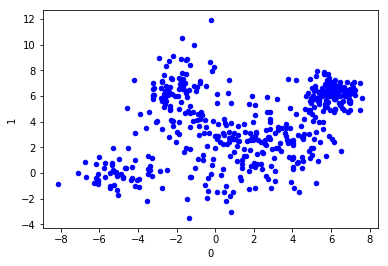

In [4]:
alphas = np.array([0.1, 0.2, 0.3, 0.4])
cov = ([[1,0],[0,1]],[[1,0],[0,3]],[[0.5,0],[0,0.5]],[[4,1],[1,4]])
#print(cov[0])
sigmas = np.zeros([4,2,2])
for i in range(4):
    sigmas[i] = scipy.linalg.sqrtm(cov[i])
num_cluster = [0,1,2,3]
mus = np.array([[-5,0],[-2,6],[6,6],[2, 2]])



def marsaglia_bray(n):
    '''

    :param n: length of the sequence
    :return: sequence of x_i normally distributed
    '''
    x = np.zeros([n,2])
    for i in range(n):
        s = 2
        while (s > 1):
            u = np.random.uniform(0,1)
            v = np.random.uniform(0,1)
            u = 2 * u - 1
            v = 2 * v - 1
            s = v ** 2 + u ** 2
        x[i,0] = u * np.sqrt(- 2 * np.log(s) / s)
        x[i,1] = v * np.sqrt(- 2 * np.log(s) / s)


    #count, bins, ignored = plt.hist(x, 100, normed=True)
    #plt.show()

    return (x)

def make_data(nb):

    data = np.zeros([nb, 2])
    clusters = discrete_distrib(alphas, num_cluster, nb)

    for i in range(nb):
        k = int(clusters[i])
        data[i,:] = np.dot(sigmas[k], marsaglia_bray(1)[0]) + mus[k]
    return(data)

data = make_data(500)
data = pd.DataFrame(data)
data.plot(kind = 'scatter', x = 0, y = 1, color = 'blue')
plt.show()

Here we use k_means. k_means will initialize the EM algorithm.

/Users/gregoire/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


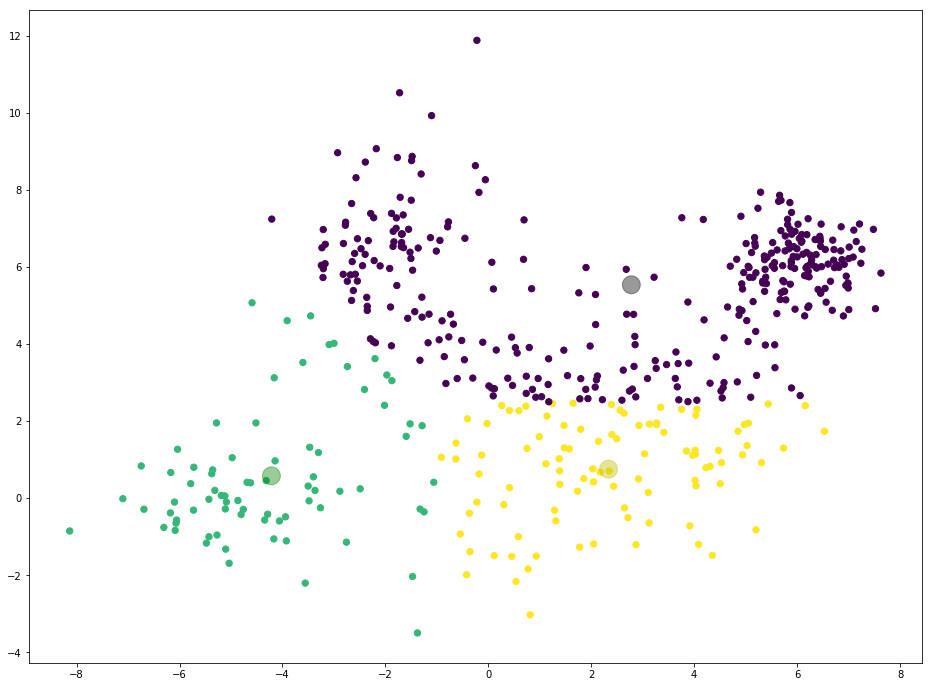

Distorsion : 1610.93817415


()

In [6]:
def k_means(data, n_centers, it=50):
    # random initialization
    centers = np.random.randint(-10, 10, size=[n_centers, 2])
    # print(centers)
    new_centers = np.zeros(shape=[n_centers, 2])
    distances = np.zeros([n_centers, data.shape[0]])
    point_center = np.zeros(data.shape[0])
    compteur = 0

    while np.array_equal(new_centers, centers) == False and compteur < it:

        for i in range(data.shape[0]):
            for k in range(n_centers):
                distances[k, i] = np.linalg.norm(centers[k] - np.array(data)[i])
            point_center[i] = np.argmin(distances[:, i])

        # computing centroïds
        for k in range(n_centers):
            centroid = np.zeros(2)
            compt = 0
            for i in range(data.shape[0]):
                if point_center[i] == k:
                    centroid = np.sum([centroid, np.array(data)[i]], axis=0)
                    compt += 1
            new_centers[k] = centroid / compt

        centers[:] = new_centers
        compteur += 1

        distorsion = 0

        for i in range(data.shape[0]):
            distorsion += np.linalg.norm(np.array(data)[i] - centers[int(point_center[i])])

    return (new_centers, point_center, distorsion)


def k_means_plot(data):
    centers, point_center, distorsion = k_means(data, 4)
    data_array = np.array(data)
    plt.figure(figsize=(16, 12))
    plt.scatter(data_array[:, 0], data_array[:, 1], c=point_center, s=40, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c=['k', 'b', 'g', 'y'], s=320, alpha=0.4)
    plt.show()
    print('Distorsion :', distorsion)

    return ()


k_means_plot(data)

Finally we implement EM.

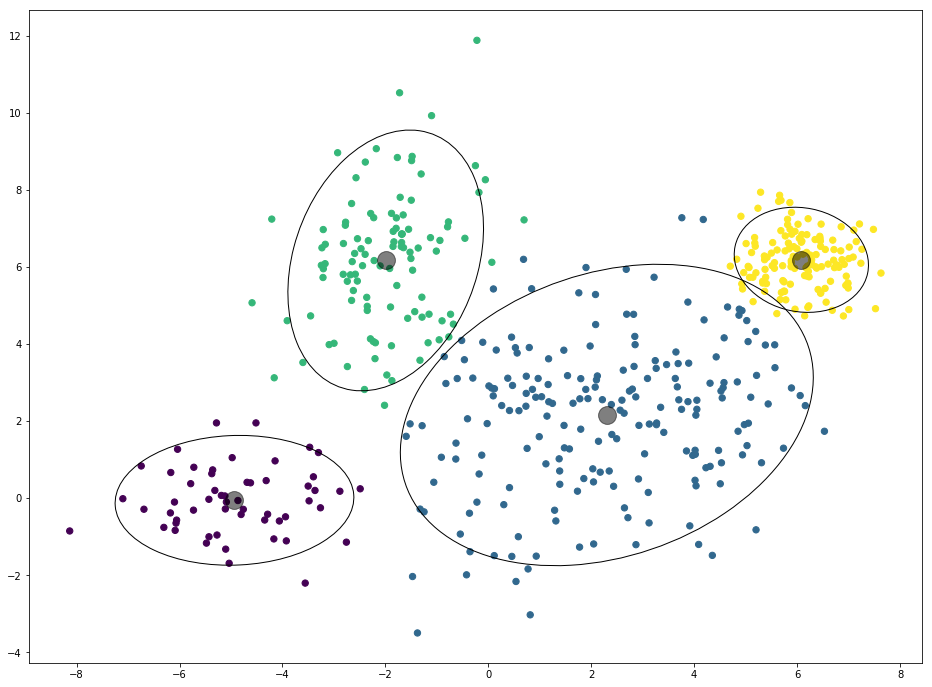

()

In [8]:
def gaussian_density(mu, cov_matrix, data_point):
    value = (1 / (2 * np.pi * (np.linalg.det(cov_matrix)) ** 0.5)) * np.exp(
        -np.dot((data_point - mu).T, np.dot(np.linalg.inv(cov_matrix), (data_point - mu))))

    return (value)

def pi_update(q):
    pi_k = np.zeros(q.shape[1])
    denom = np.sum(q)

    for i in range(q.shape[1]):
        pi_k[i] = sum(q[:, i]) / denom

    return (pi_k)

def q_update(data, mu_k, sigma_k, pi_k):
    q = np.zeros([data.shape[0], mu_k.shape[0]])

    for i in range(data.shape[0]):

        denom = 0
        for j in range(mu_k.shape[0]):
            denom += pi_k[j] * gaussian_density(mu_k[j], sigma_k[j], np.array(data)[i])

        for j in range(mu_k.shape[0]):
            num = pi_k[j] * gaussian_density(mu_k[j], sigma_k[j], np.array(data)[i])
            q[i, j] = num / denom

    return (q)

def mu_update(data, q):
    mu_k = np.zeros([q.shape[1], 2])

    for i in range(q.shape[1]):
        truc = np.array(data)
        num = np.dot(np.transpose(truc), q[:, i])
        denom = sum(q[:, i])
        mu_k[i] = num / denom

    return (mu_k)

def sigma_update(data, mu_k, q):
    sigma_k = np.empty(shape=q.shape[1], dtype=np.ndarray)

    for i in range(q.shape[1]):
        num = 0
        for j in range(q.shape[0]):
            num += np.outer((np.array(data)[j] - mu_k[i]), np.transpose((np.array(data)[j] - mu_k[i]))) * q[j, i]
        denom = sum(q[:, i])
        sigma_k[i] = num / denom
    return (sigma_k)


def em(data, k, it=30):
    pi_k = np.zeros(k)
    sigma_k = sigma_k = np.empty(shape=k, dtype=np.ndarray)
    q = np.zeros([data.shape[0], k])

    # k-means initialisation
    mu_k, point_mu_k, distorsion = k_means(data, k)
    for i in range(data.shape[0]):
        q[i, np.int(point_mu_k[i])] = 1

    pi_k = pi_update(q)
    # mu_k = mu_update(data, q)
    sigma_k = sigma_update(data, mu_k, q)

    truc = 0

    while truc < it:
        # expectation-step
        q = q_update(data, mu_k, sigma_k, pi_k)

        # maximization-step
        pi_k = pi_update(q)
        mu_k = mu_update(data, q)
        sigma_k = sigma_update(data, mu_k, q)

        # print('mu :', mu_k,
        #      'sigma :', sigma_k,
        #      'q :', q,
        #      'pi :', pi_k)

        truc += 1

    return (q, mu_k, pi_k, sigma_k)


q_, mu_k_, pi_k_, sigma_k_ = em(data, 4)

def em_plot(data, k):
    q, mu_k, pi_k, sigma_k = em(data, k, it=20)

    plt.figure(figsize=(16, 12))
    ax = plt.subplot(111)

    cluster = np.zeros(data.shape[0])
    for i in range(q.shape[0]):
        cluster[i] = np.argmax(q[i, :])

    data_array = np.array(data)
    plt.scatter(data_array[:, 0], data_array[:, 1], c=cluster, s=40, cmap='viridis')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='black', s=320, alpha=0.5)

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    nstd = 2

    for i in range(k):
        cov = sigma_k[i]
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        w, h = 2 * nstd * np.sqrt(vals)
        ell = Ellipse(xy=mu_k[i],
                      width=w, height=h,
                      angle=theta, color='black')
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.show()

    return ()


em_plot(data, 4)

Application : here we apply EM on a new dataset, 'Crude Birth/Death Rate'.

In [27]:
un_data = pd.read_excel('/Users/gregoire/PycharmProjects/comput_stat_hwk2/WPP2017_POP_F03_RATE_OF_NATURAL_INCREASE.xlsx')

In [28]:
un_data

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United Nations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Population Division,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Department of Economic and Social Affairs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,World Population Prospects: The 2017 Revision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,File POP/3: Rate of natural increase by region...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Estimates, 1950 - 2015",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,POP/DB/WPP/Rev.2017/POP/F03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
un_data.drop('Unnamed: 0', axis = 1)
un_data.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13])

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
14,Index,Variant,"Region, subregion, country or area *",Notes,Country code,1950-1955,1955-1960,1960-1965,1965-1970,1970-1975,1975-1980,1980-1985,1985-1990,1990-1995,1995-2000,2000-2005,2005-2010,2010-2015
15,1,Estimates,WORLD,NaN,900,17.78,17.981,19.23,20.51,19.461,17.772,17.804,17.92,15.179,13.232,12.522,12.326,11.85
16,2,Estimates,More developed regions,a,901,11.788,11.628,10.143,7.76,6.499,5.277,4.697,4.196,2.305,0.978,0.731,1.32,1.126
17,3,Estimates,Less developed regions,b,902,20.555,20.795,23.046,25.487,24.126,21.936,21.847,21.83,18.584,16.267,15.274,14.761,14.101
18,4,Estimates,Least developed countries,c,941,20.151,22.711,24.638,26.209,26.433,27.121,28.495,28.082,26.821,26.628,26.313,25.984,25.188
19,5,Estimates,"Less developed regions, excluding least develo...",d,934,20.607,20.55,22.84,25.393,23.826,21.257,20.959,20.972,17.406,14.703,13.507,12.858,12.109
20,6,Estimates,"Less developed regions, excluding China",NaN,948,20.961,23.471,24.75,25.09,24.997,24.854,24.75,23.378,21.446,19.73,18.454,17.661,16.758
21,7,Estimates,High-income countries,e,1503,11.915,11.861,10.997,9.119,7.755,6.457,5.963,5.333,4.762,3.807,3.371,3.454,2.675
22,8,Estimates,Middle-income countries,e,1517,19.985,19.951,21.847,23.952,22.589,20.387,20.273,20.342,16.683,14.135,13.115,12.629,12.035
23,9,Estimates,Upper-middle-income countries,e,1502,20.702,18.474,20.822,24.152,21.522,17.234,16.69,17.909,12.57,9.102,8.018,7.754,7.645


I did not really know what to do since this is only birth rate minus death rate and not the birth vs. death...